# Introduction

This notebook contains an analysis of the simulation `LRC`. A receptor with $D = 0.01$ $\mu$m$^2/$s is diffusing freely in a large absorbing corral. An invisible ligand with $D=0.1$ $\mu$m$^2/$s is diffusing also freely uniformly in the whole space. The ligand and receptor can interact and form a complex with a slightly slower diffusion coefficient $D = 0.005$ $\mu$m$^2/$s. Some complexes are also introduced initially inside de corral. 

In [1]:
#!pip install pandas seaborn scikit-learn lmfit mahotas imread
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Functions.functions import TE_MSD,Michalet,set_size,pool_data
from sklearn.cluster import KMeans
import matplotlib as mpl
import seaborn as sns
import random

%matplotlib inline
%reload_ext autoreload

# Experimental condition
dt = 0.05

# Initial filtering
minframe=12
maxframe=100000
rsquared_threshold=-1000

# Exact trajectories

We can bypass the tracking section by using Smoldyn's `listmol2` function which exports to a text file the position of all the particles in the system at all desired time steps. 

In [2]:
#Preprocess the Smoldyn exact trajectories
data = pd.read_csv('LRC/output.txt', sep=" ", header=None)
data.columns = ["iteration", "SPECIES", "STATE", "POSITION_X","POSITION_Y","TRACK_ID"]
print(np.unique(data['SPECIES'].values))
data[["POSITION_X","POSITION_Y","TRACK_ID"]][(data['SPECIES']==1) | (data['SPECIES']==3)].to_csv('LRC/temp.csv',index=None)

[1 2 3]


In [3]:
files = ["LRC/temp.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=4,display_id=True)

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  12 , maxframe =  100000 , R2 threshold =  -1000
Fit option:  4
Reading filenames in  ['LRC/temp.csv'] ...
Analysis for LRC/temp.csv ...
Track 0 out of 591
Track 1 out of 591
Track 2 out of 591
Track 3 out of 591
Track 4 out of 591
Track 5 out of 591
Track 6 out of 591
Track 7 out of 591
Track 8 out of 591
Track 9 out of 591
Track 10 out of 591
Track 11 out of 591
Track 12 out of 591
Track 13 out of 591
Track 14 out of 591
Track 15 out of 591
Track 16 out of 591
Track 17 out of 591
Track 18 out of 591
Track 19 out of 591
Track 20 out of 591
Track 21 out of 591
Track 22 out of 591
Track 23 out of 591
Track 24 out of 591
Track 25 out of 591
Track 26 out of 591
Track 27 out of 591
Track 28 out of 591
Track 29 out of 591
Track 30 out of 591
Track 31 out of 591
Track 32 out of 591
Track 33 out of 591
Track 34 out of 591
Track 35 out of 591
Track 36 out of 591
Track 37 out of 591
Track 38 out of 591
Track 39 out of 591
T

Track 386 out of 591
Track 387 out of 591
Track 388 out of 591
Track 389 out of 591
Track 390 out of 591
Track 391 out of 591
Track 392 out of 591
Track 393 out of 591
Track 394 out of 591
Track 395 out of 591
Track 396 out of 591
Track 397 out of 591
Track 398 out of 591
Track 399 out of 591
Track 400 out of 591
Track 401 out of 591
Track 402 out of 591
Track 403 out of 591
Track 404 out of 591
Track 405 out of 591
Track 406 out of 591
Track 407 out of 591
Track 408 out of 591
Track 409 out of 591
Track 410 out of 591
Track 411 out of 591
Track 412 out of 591
Track 413 out of 591
Track 414 out of 591
Track 415 out of 591
Track 416 out of 591
Track 417 out of 591
Track 418 out of 591
Track 419 out of 591
Track 420 out of 591
Track 421 out of 591
Track 422 out of 591
Track 423 out of 591
Track 424 out of 591
Track 425 out of 591
Track 426 out of 591
Track 427 out of 591
Track 428 out of 591
Track 429 out of 591
Track 430 out of 591
Track 431 out of 591
Track 432 out of 591
Track 433 out

# Gaussian mixture to identify clusters

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

temp = df[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)

gmm = GaussianMixture(n_components=2,max_iter=3000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=1000)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)

colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]
df['GM_Label']=colorlist

#Try to determine automatically the index for the confined group
index = [0,1]
D_per_group = []
for indx in index:
    Dmean = df['D'][(df['GM_Label']==indx)].mean()
    D_per_group.append(Dmean)

index_complex = D_per_group.index(min(D_per_group))
index_receptor = list(filter(lambda x : x != index_complex, index)) #careful, two different indexes

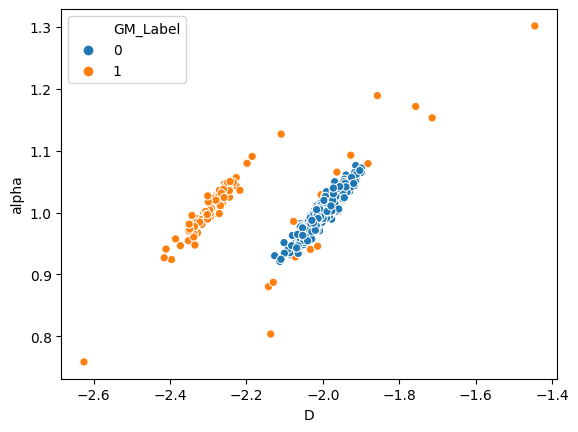

In [5]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.scatterplot(x='D',y='alpha',hue='GM_Label',data=df)
plt.show()

# MSDs with cluster label

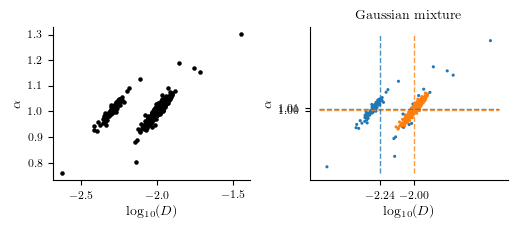

In [6]:
c1 = 'tab:blue'
c2 = 'tab:orange'

D = df['D'].values
alpha = df['alpha'].values
labels_GM = df['GM_Label'].values
labels_GM_rgb = [c1 if x==index_complex else c2 for x in labels_GM]

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=1))
grid = plt.GridSpec(1, 2, wspace=0.3, hspace=0.,bottom=0.5,left=0.2)
ax0 = fig.add_subplot(grid[0,0])
ax1 = fig.add_subplot(grid[0,1])

ax0.scatter(D,alpha,c='k',s=5)
ax0.set_xlabel(r'log$_{10}(D)$')
ax0.set_ylabel(r'$\alpha$')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(D,alpha,c=labels_GM_rgb,s=5,edgecolors='w',linewidths=0.001)
ax1.set_xlabel(r'log$_{10}(D)$')
ax1.set_ylabel(r'$\alpha$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xmin, xmax = ax1.get_xlim()
meanalpha1 = df['alpha'][(df['GM_Label']==index_complex)].mean()
meanalpha0 = df['alpha'][(df['GM_Label']==index_receptor[0])].mean()
ax1.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax1.get_ylim()
meanD1 = df['D'][(df['GM_Label']==index_complex)].mean()
meanD0 = df['D'][(df['GM_Label']==index_receptor[0])].mean()
ax1.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_xticks([round(meanD1,2),round(meanD0,2)])
ax1.set_title('Gaussian mixture',fontsize=10)

fig.savefig('LRC/Plots/lrc_exact_gaussian_mixture.pdf', format='pdf', bbox_inches='tight')
plt.show()

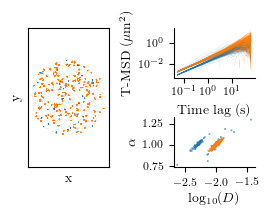

In [7]:
X = list(df['x'].values)
Y = list(df['y'].values)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(300))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = labels_GM_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    
trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
alpha = df['alpha'].values
logD = df['D'].values
features.scatter(logD,alpha,color=labels_GM_rgb,s=0.1)
features.set_xlabel(r'log$_{10}(D)$')
features.set_ylabel(r'$\alpha$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=labels_GM_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('LRC/Plots/lrc_exact_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Specific analysis, careful, this is very slow due to the very long exact tracks

#############################################
############## PROGRAM MICHALET #############
#############################################
Compute the TE-MSD and ensemble variance...
Number of T-MSDs at time lag  0.05  =  107
Number of T-MSDs at time lag  0.1  =  107
Number of T-MSDs at time lag  0.15  =  107
Number of T-MSDs at time lag  0.2  =  107
Number of T-MSDs at time lag  0.25  =  107
Number of T-MSDs at time lag  0.3  =  107
Number of T-MSDs at time lag  0.35  =  107
Number of T-MSDs at time lag  0.4  =  107
Number of T-MSDs at time lag  0.45  =  107
Number of T-MSDs at time lag  0.5  =  107
Number of T-MSDs at time lag  0.55  =  107
Number of T-MSDs at time lag  0.6  =  106
Number of T-MSDs at time lag  0.65  =  106
Number of T-MSDs at time lag  0.7  =  106
Number of T-MSDs at time lag  0.75  =  106
Number of T-MSDs at time lag  0.8  =  106
Number of T-MSDs at time lag  0.85  =  106
Number of T-MSDs at time lag  0.9  =  106
Number of T-MSDs at time lag  0.95  =  106
Number of 

Number of T-MSDs at time lag  25.5  =  77
Number of T-MSDs at time lag  25.55  =  77
Number of T-MSDs at time lag  25.6  =  77
Number of T-MSDs at time lag  25.65  =  77
Number of T-MSDs at time lag  25.7  =  77
Number of T-MSDs at time lag  25.75  =  77
Number of T-MSDs at time lag  25.8  =  77
Number of T-MSDs at time lag  25.85  =  77
Number of T-MSDs at time lag  25.9  =  77
Number of T-MSDs at time lag  25.95  =  77
Number of T-MSDs at time lag  26.0  =  77
Number of T-MSDs at time lag  26.05  =  77
Number of T-MSDs at time lag  26.1  =  77
Number of T-MSDs at time lag  26.15  =  77
Number of T-MSDs at time lag  26.2  =  76
Number of T-MSDs at time lag  26.25  =  76
Number of T-MSDs at time lag  26.3  =  76
Number of T-MSDs at time lag  26.35  =  76
Number of T-MSDs at time lag  26.4  =  76
Number of T-MSDs at time lag  26.45  =  76
Number of T-MSDs at time lag  26.5  =  76
Number of T-MSDs at time lag  26.55  =  76
Number of T-MSDs at time lag  26.6  =  76
Number of T-MSDs at tim

Number of T-MSDs at time lag  49.9  =  58
Number of T-MSDs at time lag  49.95  =  58
Number of T-MSDs at time lag  50.0  =  58
Number of T-MSDs at time lag  50.05  =  58
Number of T-MSDs at time lag  50.1  =  58
Number of T-MSDs at time lag  50.15  =  58
Number of T-MSDs at time lag  50.2  =  58
Number of T-MSDs at time lag  50.25  =  58
Number of T-MSDs at time lag  50.3  =  58
Number of T-MSDs at time lag  50.35  =  58
Number of T-MSDs at time lag  50.4  =  58
Number of T-MSDs at time lag  50.45  =  58
Number of T-MSDs at time lag  50.5  =  58
Number of T-MSDs at time lag  50.55  =  58
Number of T-MSDs at time lag  50.6  =  58
Number of T-MSDs at time lag  50.65  =  58
Number of T-MSDs at time lag  50.7  =  58
Number of T-MSDs at time lag  50.75  =  58
Number of T-MSDs at time lag  50.8  =  58
Number of T-MSDs at time lag  50.85  =  58
Number of T-MSDs at time lag  50.9  =  58
Number of T-MSDs at time lag  50.95  =  58
Number of T-MSDs at time lag  51.0  =  58
Number of T-MSDs at tim

Done. The ensemble covariance matrix has been generated from the set of MSD tracks.
Initial run to determine the best theoretical values for D and sigma.
Reading MSD tracklengths...
Generate linear MSD with D =  0.07  and epsilon =  0.36 ...
Computing the the theoretical variance at each time lag for each MSD tracklength...
Performing the ensemble average of the variances associated to each MSD track...
The MSD, variance and time lag arrays are cut at  5 s...
Done. The linear model for the MSD and its variance have been generated.
Reading MSD tracklengths...
Compute covariance map for each track length...
Build intermediary series of matrices cut to  5  s...
Compute the ensemble average of the covariance matrices...
Done. The ensemble covariance matrix has been generated from the set of MSD tracks.
The error on the slope is computed for each number of fitting points, based on the provided variance and covariance. The method used is weighted least squares...
Done. The relative error for

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:772: RuntimeWarning: invalid value encountered in sqrt
  loc_sigma = round(np.sqrt(model.intercept_/4),4)


The MSD, variance and time lag arrays are cut at  5 s...
Done. The linear model for the MSD and its variance have been generated.
Reading MSD tracklengths...
Compute covariance map for each track length...
Build intermediary series of matrices cut to  5  s...
Compute the ensemble average of the covariance matrices...
Done. The ensemble covariance matrix has been generated from the set of MSD tracks.
The error on the slope is computed for each number of fitting points, based on the provided variance and covariance. The method used is weighted least squares...
Done. The relative error for each number of fitting points has been computed.
The relative error on the slope is minimum for P =  2 fitting points.
The error on the slope is computed for each number of fitting points, based on the provided variance and covariance. The method used is weighted least squares...
Done. The relative error for each number of fitting points has been computed.
The relative error on the slope is minimum for 

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:772: RuntimeWarning: invalid value encountered in sqrt
  loc_sigma = round(np.sqrt(model.intercept_/4),4)


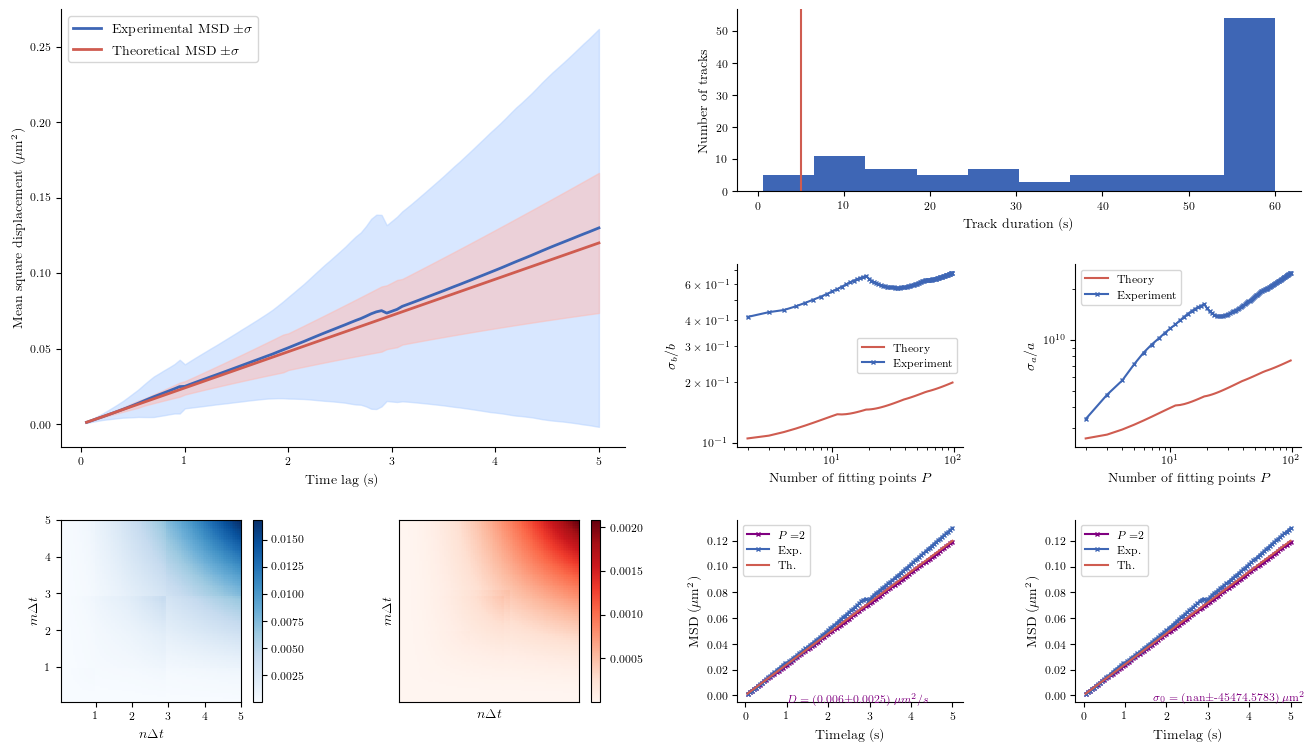

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:1011: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


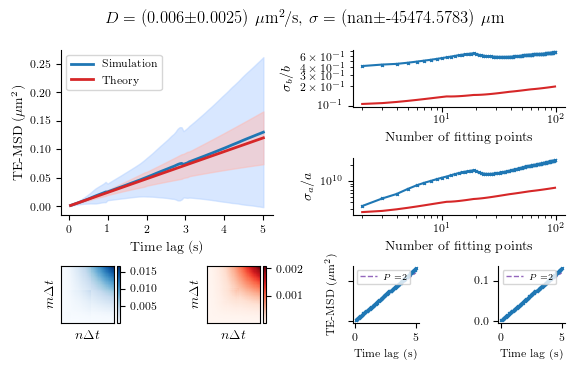

In [8]:
MSDcomplex = df['MSD'][(df['GM_Label']==index_complex)]
Michalet(MSDcomplex,cutoff=5)
plt.savefig('LRC/Plots/michalet_exact_complex.pdf')
plt.show()

#############################################
############## PROGRAM MICHALET #############
#############################################
Compute the TE-MSD and ensemble variance...
Number of T-MSDs at time lag  0.05  =  480
Number of T-MSDs at time lag  0.1  =  480
Number of T-MSDs at time lag  0.15  =  480
Number of T-MSDs at time lag  0.2  =  480
Number of T-MSDs at time lag  0.25  =  480
Number of T-MSDs at time lag  0.3  =  480
Number of T-MSDs at time lag  0.35  =  480
Number of T-MSDs at time lag  0.4  =  480
Number of T-MSDs at time lag  0.45  =  480
Number of T-MSDs at time lag  0.5  =  480
Number of T-MSDs at time lag  0.55  =  480
Number of T-MSDs at time lag  0.6  =  480
Number of T-MSDs at time lag  0.65  =  480
Number of T-MSDs at time lag  0.7  =  480
Number of T-MSDs at time lag  0.75  =  480
Number of T-MSDs at time lag  0.8  =  480
Number of T-MSDs at time lag  0.85  =  480
Number of T-MSDs at time lag  0.9  =  480
Number of T-MSDs at time lag  0.95  =  480
Number of 

Number of T-MSDs at time lag  13.8  =  476
Number of T-MSDs at time lag  13.85  =  476
Number of T-MSDs at time lag  13.9  =  476
Number of T-MSDs at time lag  13.95  =  476
Number of T-MSDs at time lag  14.0  =  476
Number of T-MSDs at time lag  14.05  =  476
Number of T-MSDs at time lag  14.1  =  476
Number of T-MSDs at time lag  14.15  =  476
Number of T-MSDs at time lag  14.2  =  476
Number of T-MSDs at time lag  14.25  =  476
Number of T-MSDs at time lag  14.3  =  476
Number of T-MSDs at time lag  14.35  =  476
Number of T-MSDs at time lag  14.4  =  476
Number of T-MSDs at time lag  14.45  =  476
Number of T-MSDs at time lag  14.5  =  476
Number of T-MSDs at time lag  14.55  =  476
Number of T-MSDs at time lag  14.6  =  476
Number of T-MSDs at time lag  14.65  =  476
Number of T-MSDs at time lag  14.7  =  476
Number of T-MSDs at time lag  14.75  =  476
Number of T-MSDs at time lag  14.8  =  476
Number of T-MSDs at time lag  14.85  =  476
Number of T-MSDs at time lag  14.9  =  476


Number of T-MSDs at time lag  26.4  =  467
Number of T-MSDs at time lag  26.45  =  467
Number of T-MSDs at time lag  26.5  =  467
Number of T-MSDs at time lag  26.55  =  467
Number of T-MSDs at time lag  26.6  =  467
Number of T-MSDs at time lag  26.65  =  467
Number of T-MSDs at time lag  26.7  =  467
Number of T-MSDs at time lag  26.75  =  467
Number of T-MSDs at time lag  26.8  =  467
Number of T-MSDs at time lag  26.85  =  467
Number of T-MSDs at time lag  26.9  =  467
Number of T-MSDs at time lag  26.95  =  467
Number of T-MSDs at time lag  27.0  =  467
Number of T-MSDs at time lag  27.05  =  467
Number of T-MSDs at time lag  27.1  =  467
Number of T-MSDs at time lag  27.15  =  467
Number of T-MSDs at time lag  27.2  =  467
Number of T-MSDs at time lag  27.25  =  467
Number of T-MSDs at time lag  27.3  =  467
Number of T-MSDs at time lag  27.35  =  466
Number of T-MSDs at time lag  27.4  =  466
Number of T-MSDs at time lag  27.45  =  466
Number of T-MSDs at time lag  27.5  =  466


Number of T-MSDs at time lag  45.05  =  454
Number of T-MSDs at time lag  45.1  =  454
Number of T-MSDs at time lag  45.15  =  454
Number of T-MSDs at time lag  45.2  =  454
Number of T-MSDs at time lag  45.25  =  454
Number of T-MSDs at time lag  45.3  =  453
Number of T-MSDs at time lag  45.35  =  453
Number of T-MSDs at time lag  45.4  =  453
Number of T-MSDs at time lag  45.45  =  453
Number of T-MSDs at time lag  45.5  =  453
Number of T-MSDs at time lag  45.55  =  453
Number of T-MSDs at time lag  45.6  =  453
Number of T-MSDs at time lag  45.65  =  453
Number of T-MSDs at time lag  45.7  =  453
Number of T-MSDs at time lag  45.75  =  453
Number of T-MSDs at time lag  45.8  =  453
Number of T-MSDs at time lag  45.85  =  453
Number of T-MSDs at time lag  45.9  =  453
Number of T-MSDs at time lag  45.95  =  453
Number of T-MSDs at time lag  46.0  =  453
Number of T-MSDs at time lag  46.05  =  453
Number of T-MSDs at time lag  46.1  =  453
Number of T-MSDs at time lag  46.15  =  453

Compute the ensemble covariance matrix with a cutoff at  5 s...
Done. The ensemble covariance matrix has been generated from the set of MSD tracks.
Initial run to determine the best theoretical values for D and sigma.
Reading MSD tracklengths...
Generate linear MSD with D =  0.07  and epsilon =  0.36 ...
Computing the the theoretical variance at each time lag for each MSD tracklength...
Performing the ensemble average of the variances associated to each MSD track...
The MSD, variance and time lag arrays are cut at  5 s...
Done. The linear model for the MSD and its variance have been generated.
Reading MSD tracklengths...
Compute covariance map for each track length...
Build intermediary series of matrices cut to  5  s...
Compute the ensemble average of the covariance matrices...
Done. The ensemble covariance matrix has been generated from the set of MSD tracks.
The error on the slope is computed for each number of fitting points, based on the provided variance and covariance. The metho

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:772: RuntimeWarning: invalid value encountered in sqrt
  loc_sigma = round(np.sqrt(model.intercept_/4),4)


Performing the ensemble average of the variances associated to each MSD track...
The MSD, variance and time lag arrays are cut at  5 s...
Done. The linear model for the MSD and its variance have been generated.
Reading MSD tracklengths...
Compute covariance map for each track length...
Build intermediary series of matrices cut to  5  s...
Compute the ensemble average of the covariance matrices...
Done. The ensemble covariance matrix has been generated from the set of MSD tracks.
The error on the slope is computed for each number of fitting points, based on the provided variance and covariance. The method used is weighted least squares...
Done. The relative error for each number of fitting points has been computed.
The relative error on the slope is minimum for P =  2 fitting points.
The error on the slope is computed for each number of fitting points, based on the provided variance and covariance. The method used is weighted least squares...
Done. The relative error for each number of 

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:772: RuntimeWarning: invalid value encountered in sqrt
  loc_sigma = round(np.sqrt(model.intercept_/4),4)


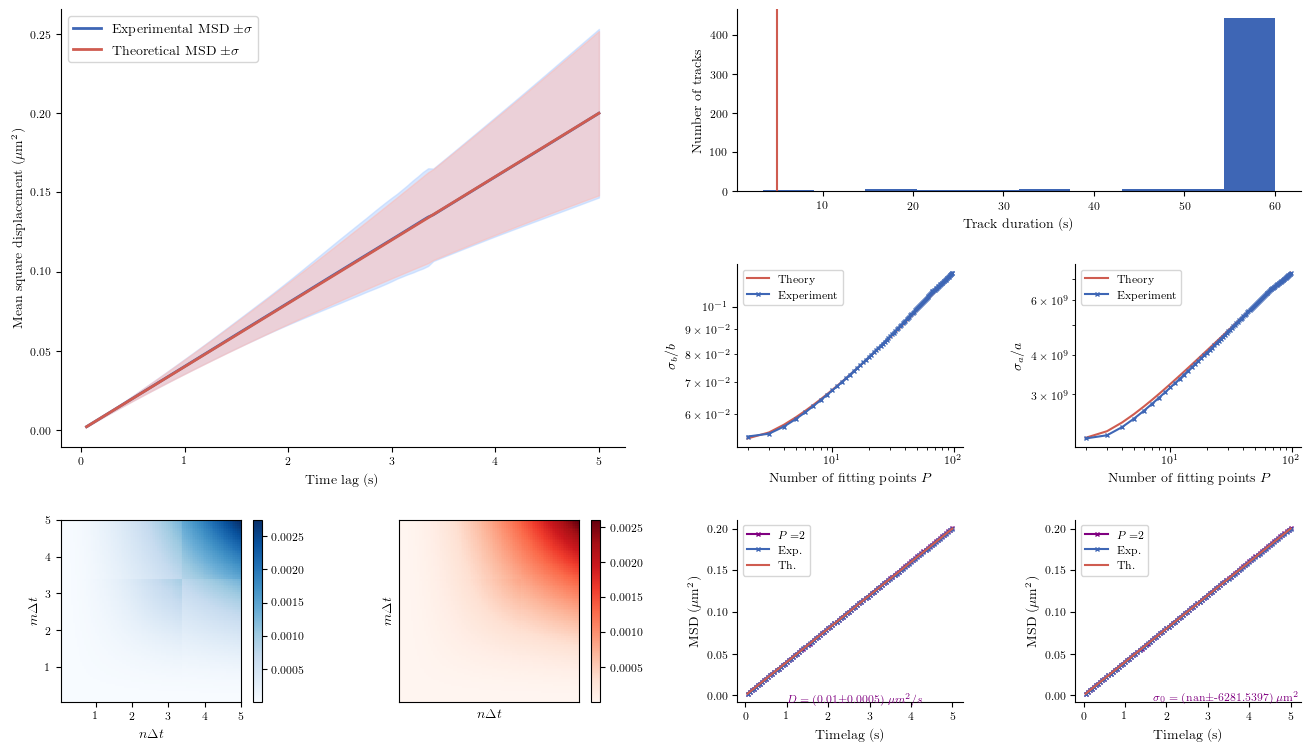

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:1011: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


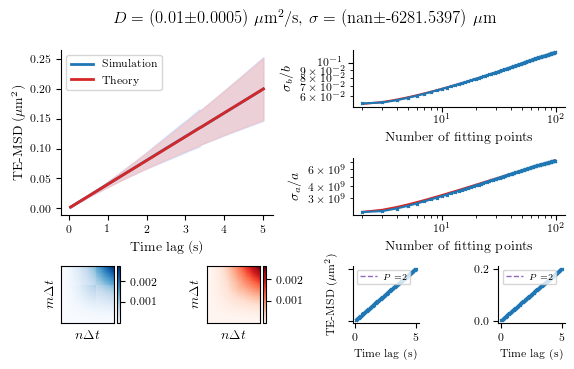

In [9]:
MSDreceptor = list(df['MSD'][(df['GM_Label']==index_receptor[0])].values)
Michalet(MSDreceptor,cutoff=5)
plt.savefig('LRC/Plots/michalet_exact_receptor.pdf')
plt.show()

# Simulated movie

In [10]:
minframe=8
files = ["LRC/movie/tracks.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=[1,4])

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  8 , maxframe =  100000 , R2 threshold =  -1000
Fit option:  [1, 4]
Reading filenames in  ['LRC/movie/tracks.csv'] ...
Analysis for LRC/movie/tracks.csv ...
19771  tracks were kept out of  397332 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.


# Select sample size 

You should take count as sample size.

In [11]:
display(df.describe())
N = 19771
samp1 = df.sample(N)

,alpha,D,c,R2,N
count,19771.000000,19771.000000,19771.000000,19771.000000,19771.000000
mean,0.424606,-2.676561,0.166789,-1.192652,15.293713
std,0.414274,0.637725,0.144184,5.959335,9.319842
min,0.100000,-4.047674,0.000851,-412.336606,8.000000
25%,0.100000,-3.173336,0.058434,-0.911878,9.000000
50%,0.231445,-2.834133,0.122209,-0.218184,12.000000
75%,0.655881,-2.282536,0.234654,0.386194,18.000000
max,2.077238,-0.287990,0.925231,0.999938,179.000000


# Test the influence of MinFrame and $R^2$

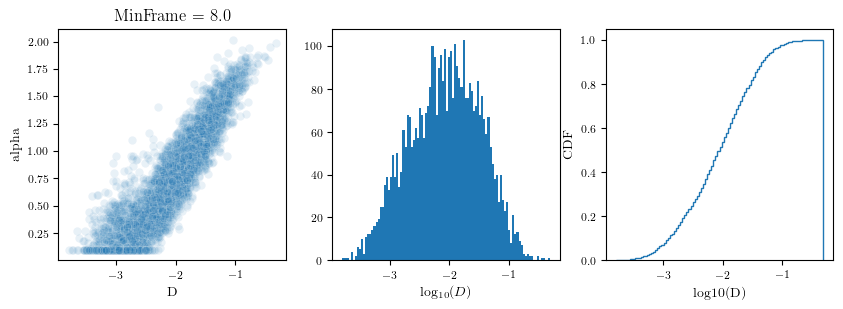

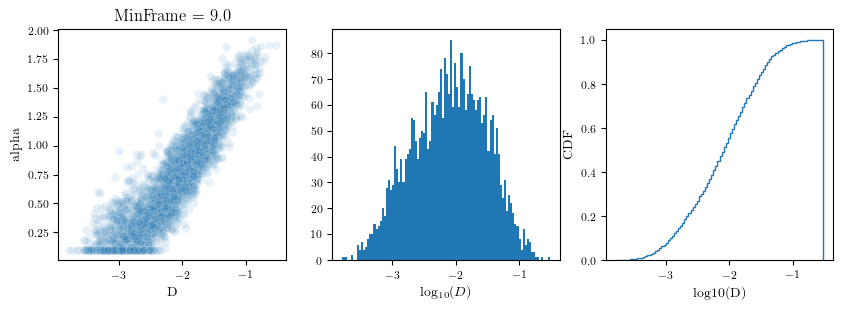

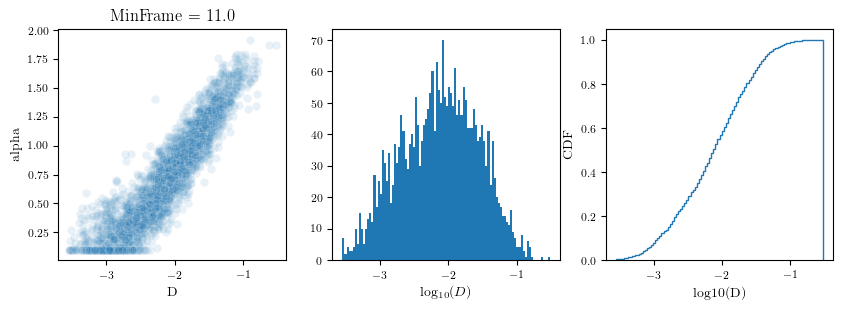

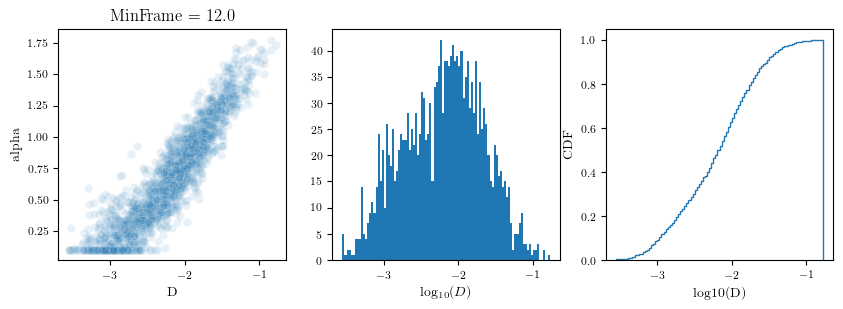

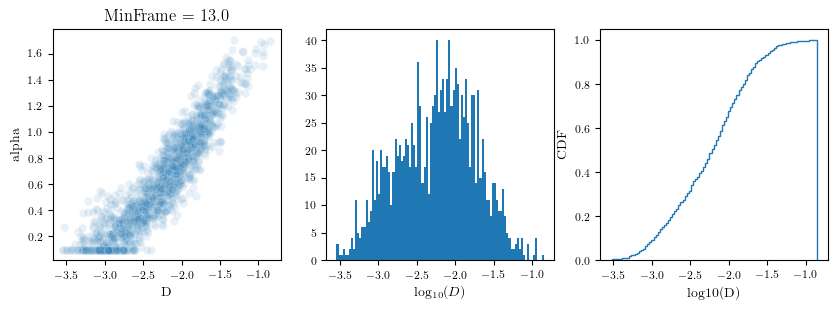

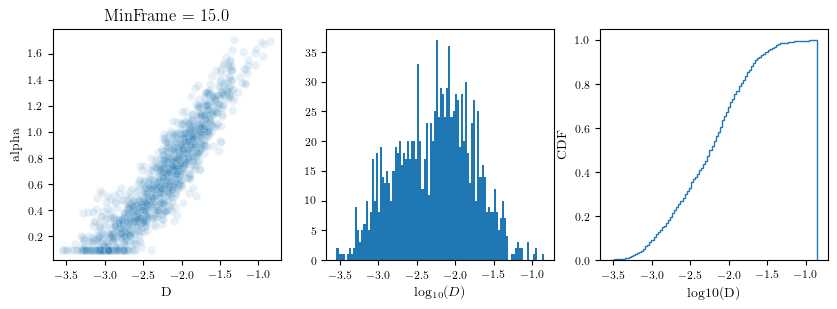

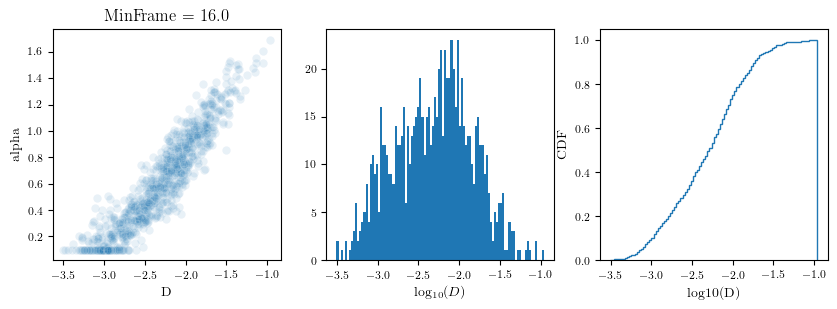

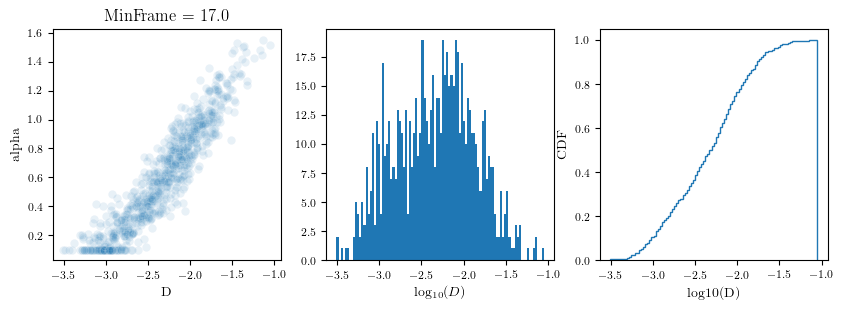

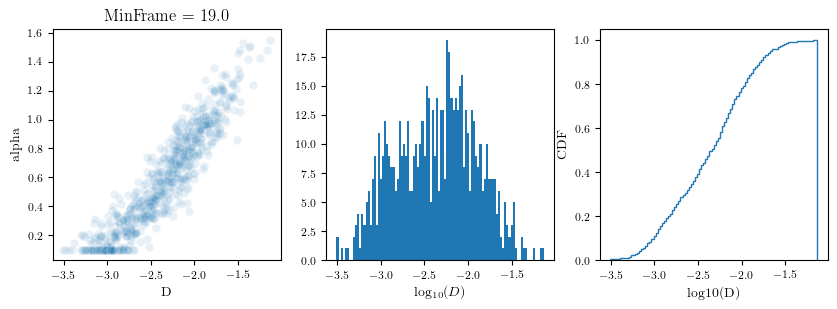

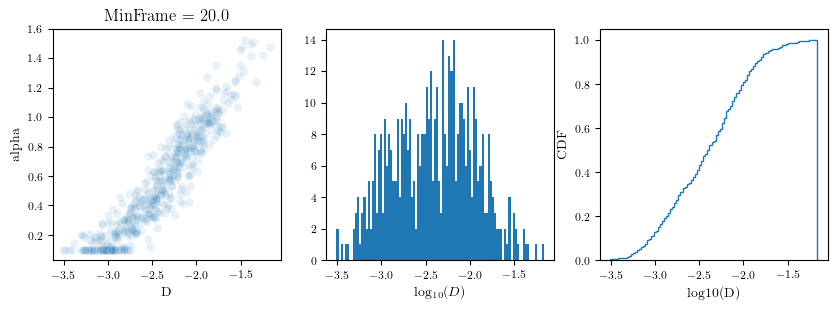

In [12]:
N = np.linspace(minframe,20,10)
for n in N:
    temp1 = samp1[(samp1['N']>n) & (samp1['R2']>0.3)]
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    
    sns.scatterplot(x='D',y='alpha',data=temp1,ax=ax[0],alpha=0.1)
    ax[0].set_title('MinFrame = '+str(round(n)))
    
    ax[1].hist(temp1['D'],bins=100)
    ax[1].set_xlabel(r'log$_{10}(D)$')
    
    ax[2].hist(temp1['D'],bins=100,density=True, histtype='step',cumulative=True)
    ax[2].set_ylabel('CDF')
    ax[2].set_xlabel('log10(D)')

    plt.show()

# Set Minframe, $R^2$ and apply a Gaussian mixture on the resulting dataset

In [13]:
minframe = 15
r2 = 0.3
df = samp1[(samp1['N']>=minframe) & (samp1['R2']>r2)]

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import *

temp = df[['alpha','D','c']].values
scaler = PowerTransformer()
scaler.fit(temp)
temp_scaled = scaler.transform(temp)

gmm = GaussianMixture(n_components=2,max_iter=1000,covariance_type='full',tol=1.0E-10,reg_covar=1.0E-10,init_params='random',n_init=500)
gmm.fit(temp_scaled)
proba_lists = gmm.predict_proba(temp_scaled)

colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]
colorlist = [np.argmax(x) for x in colored_tuples]
df['GM_Label']=colorlist

#Try to determine automatically the index for the confined group
index = [0,1]
D_per_group = []
for indx in index:
    Dmean = df['D'][(df['GM_Label']==indx)].mean()
    D_per_group.append(Dmean)

index_complex = D_per_group.index(min(D_per_group))
index_receptor = list(filter(lambda x : x != index_complex, index)) #careful, two different indexes

/home/remy13127/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


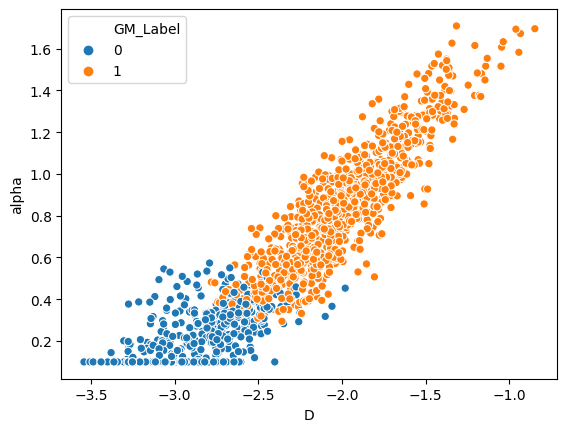

In [14]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.scatterplot(x='D',y='alpha',hue='GM_Label',data=df)
plt.show()

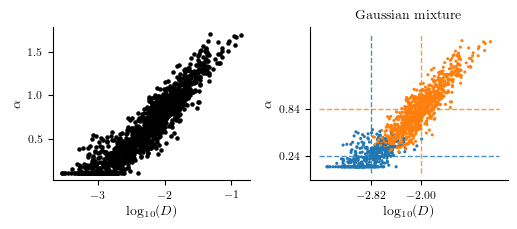

In [15]:
c1 = 'tab:blue'
c2 = 'tab:orange'

D = df['D'].values
alpha = df['alpha'].values
labels_GM = df['GM_Label'].values
labels_GM_rgb = [c1 if x==index_complex else c2 for x in labels_GM]

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=1))
grid = plt.GridSpec(1, 2, wspace=0.3, hspace=0.,bottom=0.5,left=0.2)
ax0 = fig.add_subplot(grid[0,0])
ax1 = fig.add_subplot(grid[0,1])

ax0.scatter(D,alpha,c='k',s=5)
ax0.set_xlabel(r'log$_{10}(D)$')
ax0.set_ylabel(r'$\alpha$')
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)

ax1.scatter(D,alpha,c=labels_GM_rgb,s=5,edgecolors='w',linewidths=0.001)
ax1.set_xlabel(r'log$_{10}(D)$')
ax1.set_ylabel(r'$\alpha$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

xmin, xmax = ax1.get_xlim()
meanalpha1 = df['alpha'][(df['GM_Label']==index_complex)].mean()
meanalpha0 = df['alpha'][(df['GM_Label']==index_receptor[0])].mean()
ax1.hlines(meanalpha1,xmin,xmax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.hlines(meanalpha0,xmin,xmax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_yticks([round(meanalpha1,2),round(meanalpha0,2)])

ymin, ymax = ax1.get_ylim()
meanD1 = df['D'][(df['GM_Label']==index_complex)].mean()
meanD0 = df['D'][(df['GM_Label']==index_receptor[0])].mean()
ax1.vlines(meanD1,ymin,ymax,linestyles='dashed',alpha=0.8,color=c1,linewidths=1)
ax1.vlines(meanD0,ymin,ymax,linestyles='dashed',alpha=0.8,color=c2,linewidths=1)
ax1.set_xticks([round(meanD1,2),round(meanD0,2)])
ax1.set_title('Gaussian mixture',fontsize=10)

fig.savefig('LRC/Plots/lrc_movie_gaussian_mixture.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Use the GM-determined labels to visualize trajectories and MSDs

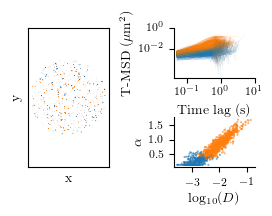

In [16]:
X = list(df['x'].values)
Y = list(df['y'].values)

mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('tex')
width = 469.75502
fig= plt.figure(figsize=set_size(width, fraction=0.45))
grid = plt.GridSpec(2, 2, wspace=0.8, hspace=0.8)
trajectories = fig.add_subplot(grid[0:2, 0],xticks=[],yticks=[])
features = fig.add_subplot(grid[1,1])
MSDs = fig.add_subplot(grid[0,1])

for x,y in zip(X,Y):
    trajectories.plot(x,y,alpha=0.05,c='k',linewidth=0.3)

random_index = np.random.randint(len(X), size=(200))
for index in random_index:
    x = X[index]
    y = Y[index]
    color = labels_GM_rgb[index]
    trajectories.plot(x,y,c=color,linewidth=0.3)
    
trajectories.set_xlabel('x')
trajectories.set_ylabel('y')
trajectories.axis('equal')

#SCATTER PLOT
alpha = df['alpha'].values
logD = df['D'].values
features.scatter(logD,alpha,color=labels_GM_rgb,s=0.1)
features.set_xlabel(r'log$_{10}(D)$')
features.set_ylabel(r'$\alpha$')
features.spines['right'].set_visible(False)
features.spines['top'].set_visible(False)
features.tick_params(axis='x', labelsize=8)
features.tick_params(axis='y', labelsize=8)

MSDSeries = list(df['MSD'].values)
for i in range(len(MSDSeries)):
    msdi = MSDSeries[i]
    timelag = np.linspace(dt,len(msdi)*dt,len(msdi))
    MSDs.plot(timelag,msdi,c=labels_GM_rgb[i],alpha=0.2,linewidth=0.25)
MSDs.set_xscale('log')
MSDs.set_yscale('log')
MSDs.set_xlabel('Time lag (s)')
MSDs.set_ylabel('T-MSD ($\mu$m$^2$)')
MSDs.spines['right'].set_visible(False)
MSDs.spines['top'].set_visible(False)
MSDs.tick_params(axis='x', labelsize=8)
MSDs.tick_params(axis='y', labelsize=8)
MSDs.set_yticks([0.01,1])
MSDs.set_xticks([0.1,1,10])

fig.savefig('LRC/Plots/lrc_movie_trajectories.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Perform specific analysis on the believed to be confined trajectories

#############################################
############## PROGRAM MICHALET #############
#############################################
Compute the TE-MSD and ensemble variance...
Number of T-MSDs at time lag  0.05  =  407
Number of T-MSDs at time lag  0.1  =  407
Number of T-MSDs at time lag  0.15  =  407
Number of T-MSDs at time lag  0.2  =  407
Number of T-MSDs at time lag  0.25  =  407
Number of T-MSDs at time lag  0.3  =  407
Number of T-MSDs at time lag  0.35  =  407
Number of T-MSDs at time lag  0.4  =  407
Number of T-MSDs at time lag  0.45  =  407
Number of T-MSDs at time lag  0.5  =  407
Number of T-MSDs at time lag  0.55  =  407
Number of T-MSDs at time lag  0.6  =  407
Number of T-MSDs at time lag  0.65  =  407
Number of T-MSDs at time lag  0.7  =  407
Number of T-MSDs at time lag  0.75  =  344
Number of T-MSDs at time lag  0.8  =  295
Number of T-MSDs at time lag  0.85  =  264
Number of T-MSDs at time lag  0.9  =  241
Number of T-MSDs at time lag  0.95  =  218
Number of 

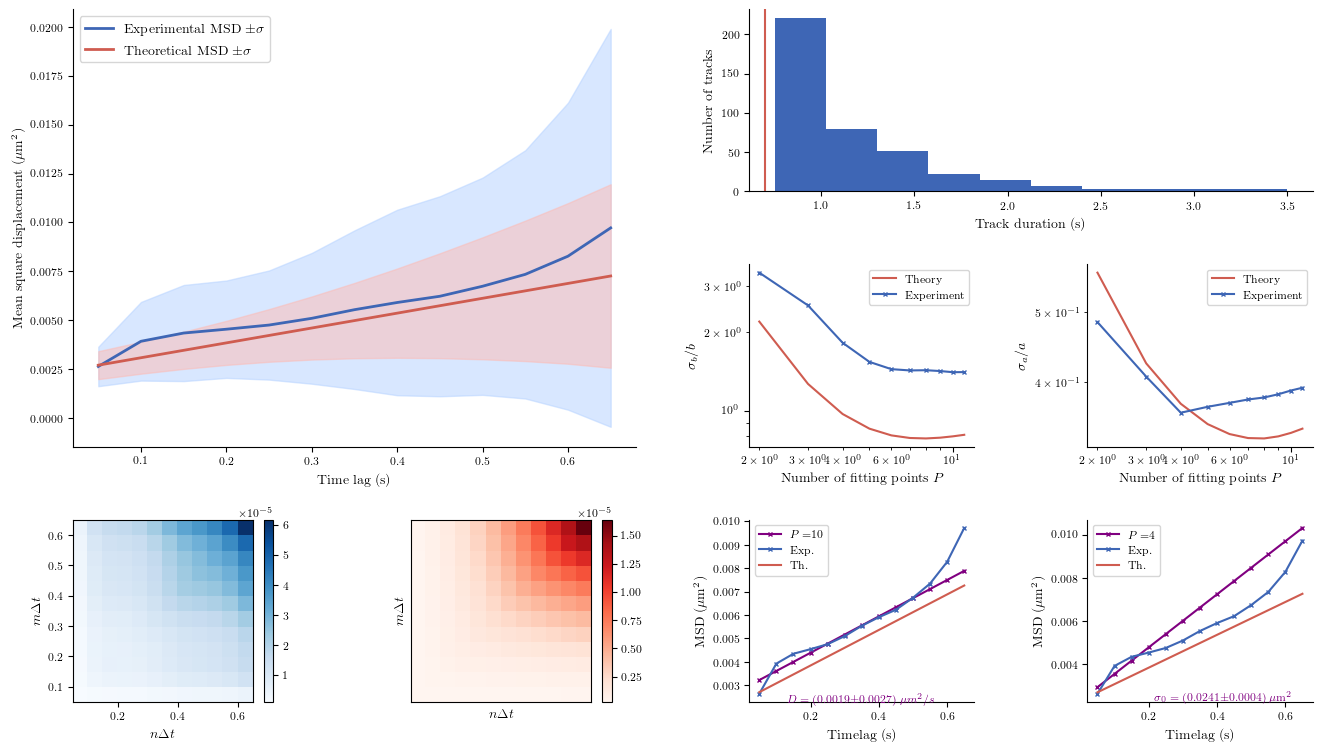

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:1011: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


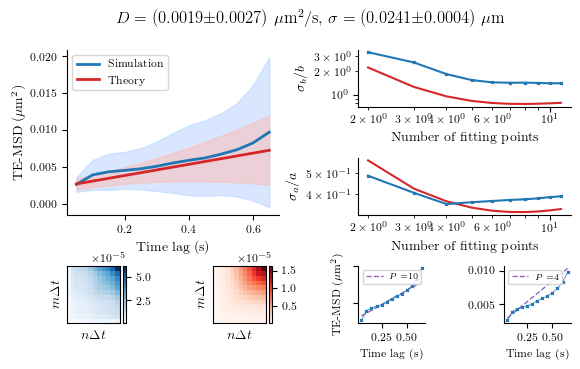

In [17]:
MSDcomplex = df['MSD'][(df['GM_Label']==index_complex)]
Michalet(MSDcomplex,cutoff=0.7)
plt.savefig('LRC/Plots/michalet_movie_complex.pdf')
plt.show()

#############################################
############## PROGRAM MICHALET #############
#############################################
Compute the TE-MSD and ensemble variance...
Number of T-MSDs at time lag  0.05  =  865
Number of T-MSDs at time lag  0.1  =  865
Number of T-MSDs at time lag  0.15  =  865
Number of T-MSDs at time lag  0.2  =  865
Number of T-MSDs at time lag  0.25  =  865
Number of T-MSDs at time lag  0.3  =  865
Number of T-MSDs at time lag  0.35  =  865
Number of T-MSDs at time lag  0.4  =  865
Number of T-MSDs at time lag  0.45  =  865
Number of T-MSDs at time lag  0.5  =  865
Number of T-MSDs at time lag  0.55  =  865
Number of T-MSDs at time lag  0.6  =  865
Number of T-MSDs at time lag  0.65  =  865
Number of T-MSDs at time lag  0.7  =  865
Number of T-MSDs at time lag  0.75  =  713
Number of T-MSDs at time lag  0.8  =  594
Number of T-MSDs at time lag  0.85  =  506
Number of T-MSDs at time lag  0.9  =  434
Number of T-MSDs at time lag  0.95  =  359
Number of 

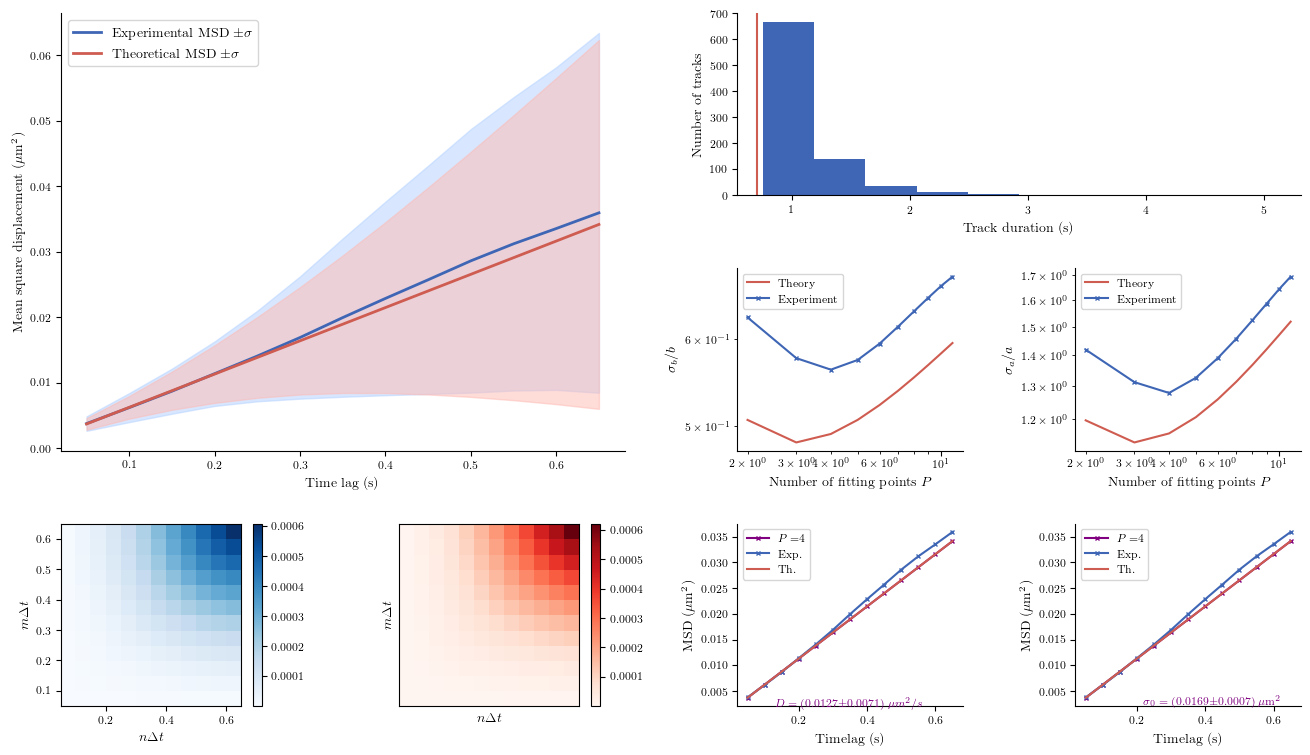

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:1011: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


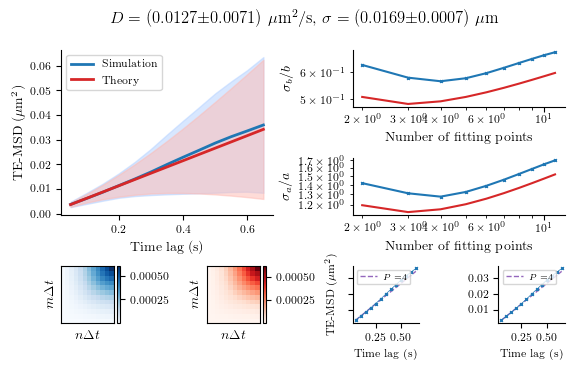

In [18]:
MSDreceptor = list(df['MSD'][(df['GM_Label']==index_receptor[0])].values)
Michalet(MSDreceptor,cutoff=0.7)
plt.savefig('LRC/Plots/michalet_movie_receptor.pdf')
plt.show()

# Let's start over with a smaller search radius $R_s = 0.095 \mu$m

In [19]:
minframe=10
files = ["LRC/movie/tracks095.csv"]
df = pool_data(files,dt,minframe,maxframe,rsquared_threshold,fit_option=[2,6])

Parameters for the MSD analysis: dt =  0.05
Initial filters: minframe =  10 , maxframe =  100000 , R2 threshold =  -1000
Fit option:  [2, 6]
Reading filenames in  ['LRC/movie/tracks095.csv'] ...
Analysis for LRC/movie/tracks095.csv ...
10661  tracks were kept out of  184953 . Done.
Generating a DataFrame...
End of the program. Returning DataFrame.


In [20]:
display(df.describe())
N = 10661
samp1 = df.sample(N)

,alpha,D,c,R2,N
count,10661.000000,10661.000000,10661.000000,10661.000000,10661.00000
mean,0.271084,-3.150019,0.103502,-1.008957,17.34856
std,0.283104,0.347209,0.087650,2.864426,8.50771
min,0.100000,-3.930383,0.000855,-132.522595,10.00000
25%,0.100000,-3.352436,0.044025,-1.036125,11.00000
50%,0.100000,-3.229443,0.079004,-0.375630,15.00000
75%,0.358310,-3.043099,0.136540,-0.030352,20.00000
max,2.019481,-0.823500,0.889538,0.999312,99.00000


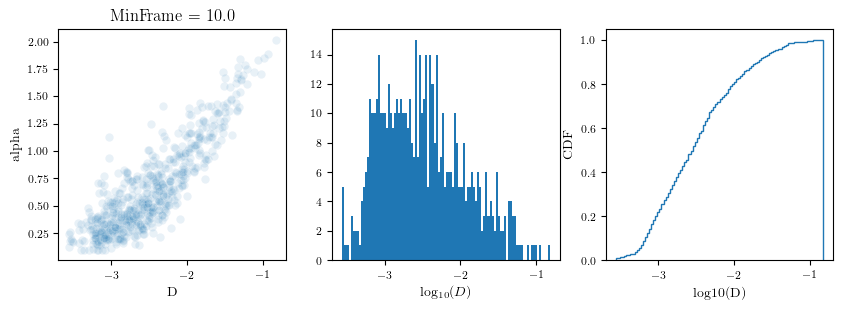

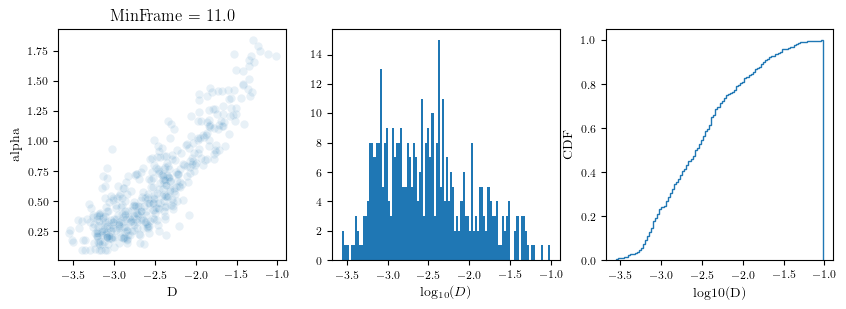

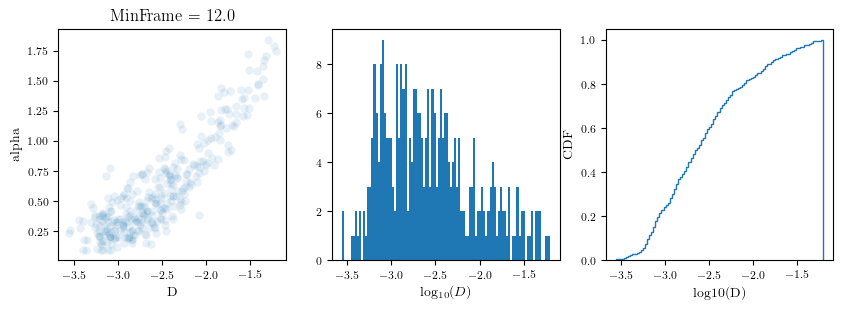

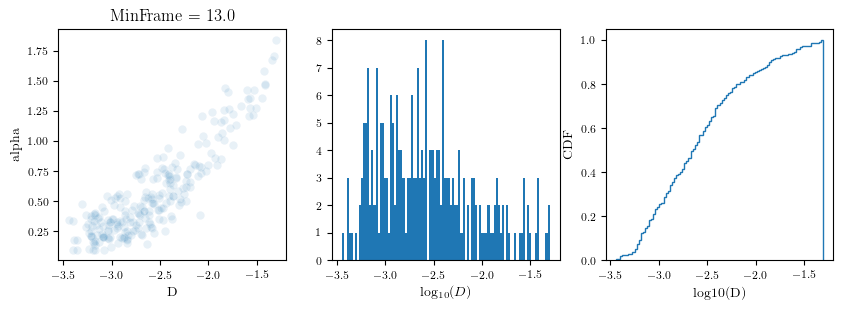

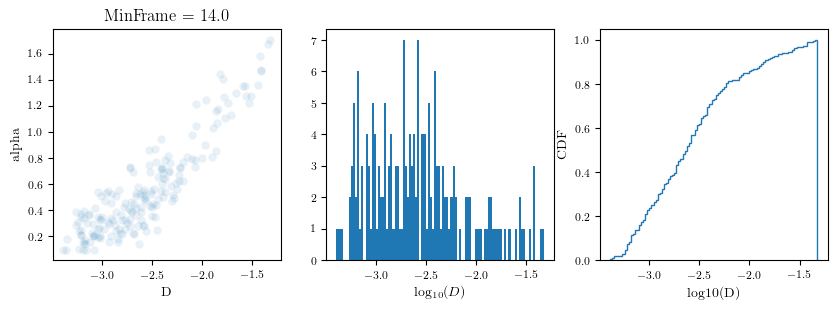

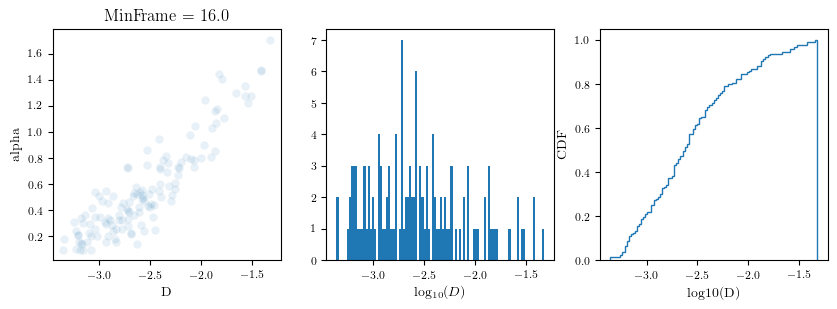

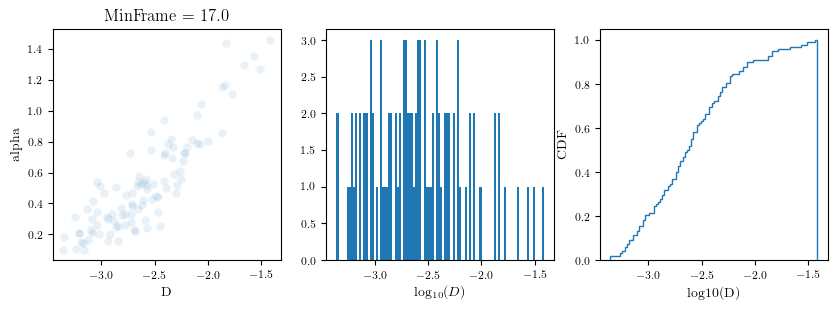

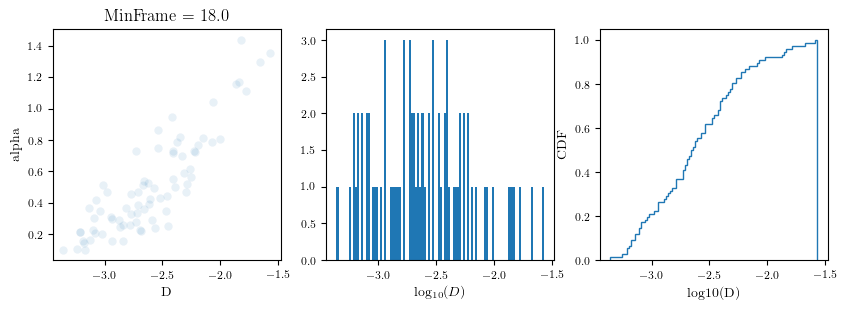

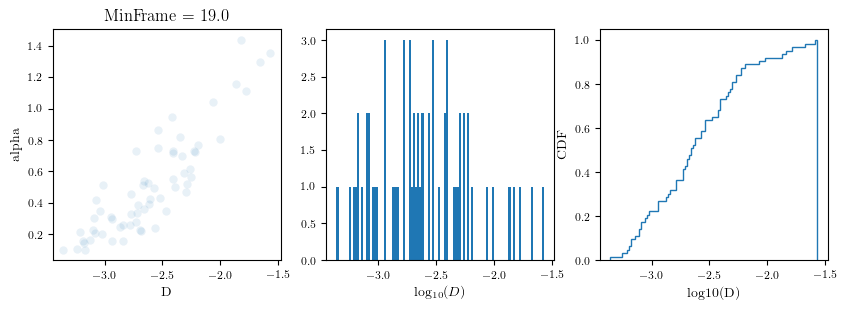

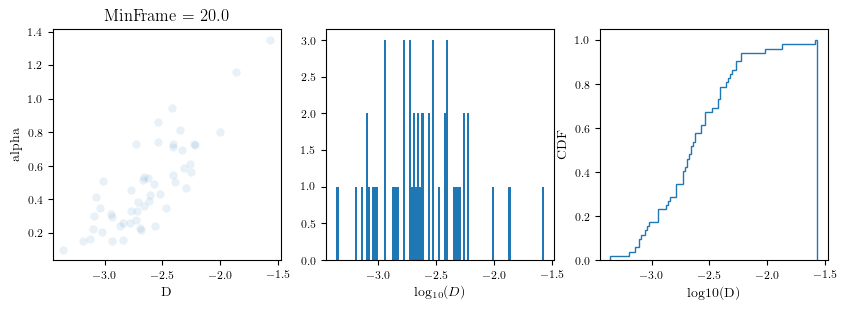

In [21]:
N = np.linspace(minframe,20,10)
for n in N:
    temp1 = samp1[(samp1['N']>n) & (samp1['R2']>0.5)]
    fig, ax = plt.subplots(1,3,figsize=(10,3))
    
    sns.scatterplot(x='D',y='alpha',data=temp1,ax=ax[0],alpha=0.1)
    ax[0].set_title('MinFrame = '+str(round(n)))
    
    ax[1].hist(temp1['D'],bins=100)
    ax[1].set_xlabel(r'log$_{10}(D)$')
    
    ax[2].hist(temp1['D'],bins=100,density=True, histtype='step',cumulative=True)
    ax[2].set_ylabel('CDF')
    ax[2].set_xlabel('log10(D)')

    plt.show()

In [22]:
minframe = 15
r2 = 0.5
df = samp1[(samp1['N']>=minframe) & (samp1['R2']>r2)]

#############################################
############## PROGRAM MICHALET #############
#############################################
Compute the TE-MSD and ensemble variance...
Number of T-MSDs at time lag  0.05  =  183
Number of T-MSDs at time lag  0.1  =  183
Number of T-MSDs at time lag  0.15  =  183
Number of T-MSDs at time lag  0.2  =  183
Number of T-MSDs at time lag  0.25  =  183
Number of T-MSDs at time lag  0.3  =  183
Number of T-MSDs at time lag  0.35  =  183
Number of T-MSDs at time lag  0.4  =  183
Number of T-MSDs at time lag  0.45  =  183
Number of T-MSDs at time lag  0.5  =  183
Number of T-MSDs at time lag  0.55  =  183
Number of T-MSDs at time lag  0.6  =  183
Number of T-MSDs at time lag  0.65  =  183
Number of T-MSDs at time lag  0.7  =  183
Number of T-MSDs at time lag  0.75  =  129
Number of T-MSDs at time lag  0.8  =  98
Number of T-MSDs at time lag  0.85  =  76
Number of T-MSDs at time lag  0.9  =  63
Number of T-MSDs at time lag  0.95  =  60
Number of T-MS

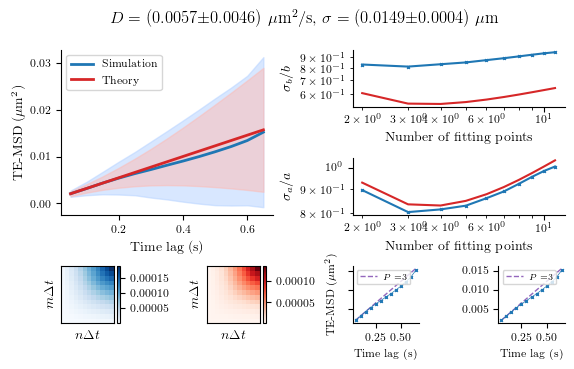

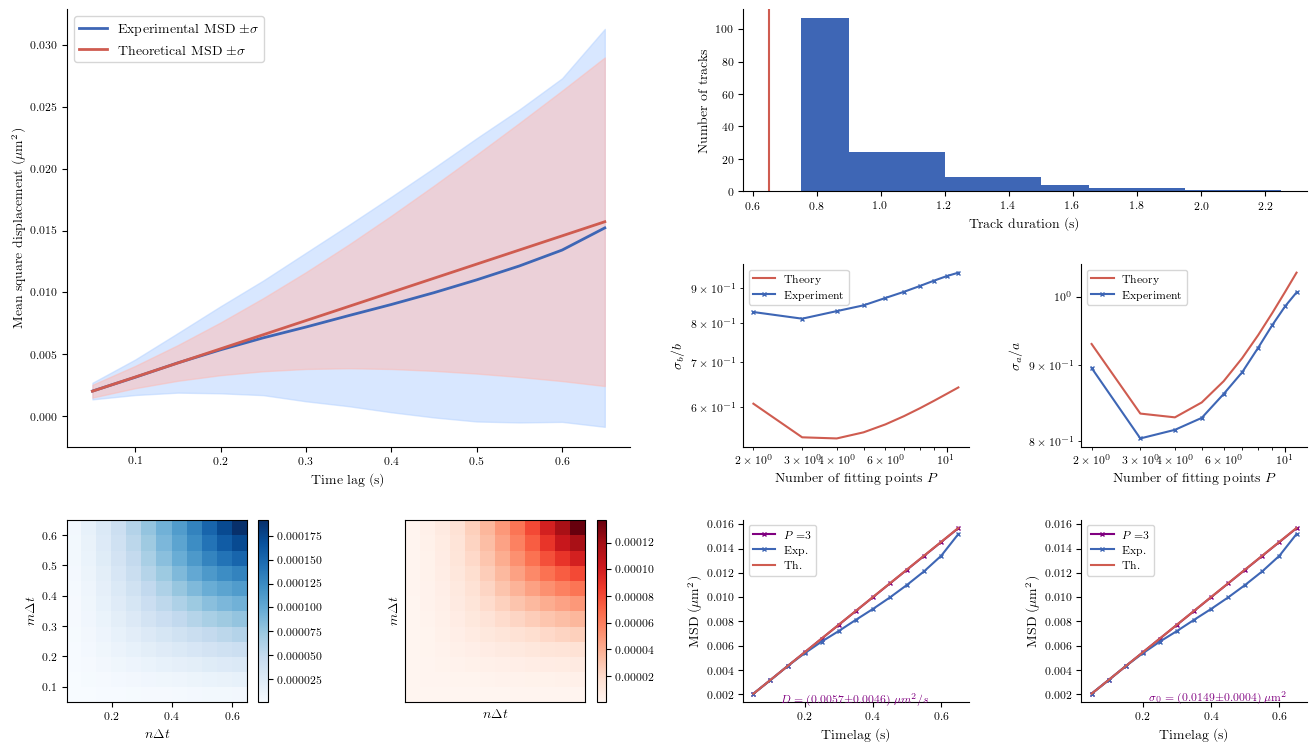

/home/remy13127/Documents/Internship/RESET/Simulations/2D/Functions/functions.py:1011: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


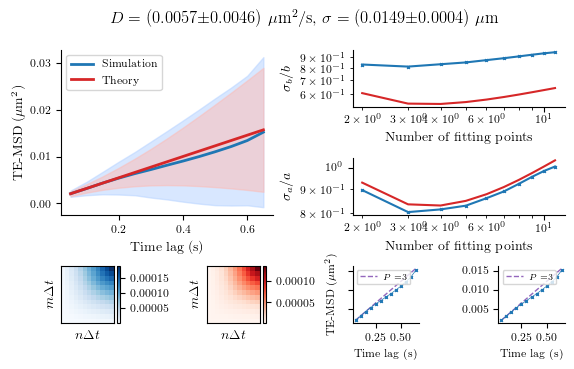

In [24]:
MSDSeries = list(df['MSD'].values)
Michalet(MSDSeries,cutoff=0.65)
plt.savefig('LRC/Plots/michalet_movie_complex_small_MLD.pdf')
plt.show()